In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
    prev_dir = os.getcwd()

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Replace with correct location
    %cd /content/drive/MyDrive/Colab Notebooks/DiffusionOfExperts

    !pip install accelerate datasets transformers wandb peft diffusers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/DiffusionOfExperts


In [ ]:
# To make our imports work because python relative imports suck
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [ ]:
import argparse
import logging
import math
import random
import shutil
from contextlib import nullcontext
from pathlib import Path
from dataclasses import dataclass
from typing import List

import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset, load_from_disk, concatenate_datasets
from huggingface_hub import create_repo, upload_folder
from packaging import version
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from torchvision import transforms
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from textwrap import wrap
import matplotlib.pyplot as plt

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params, compute_snr
from diffusers.utils import check_min_version, convert_state_dict_to_diffusers, is_wandb_available
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module

In [ ]:
@dataclass
class Config:
    pretrained_model_name_or_path: str = "CompVis/stable-diffusion-v1-4"
    datasets = ["clothes_dataset", "pixelart_dataset", "photograph_dataset"]
    learning_rate: float = 1e-04
    max_train_samples: int = 1000
    num_train_epochs: int = 20
    checkpointing_steps: int = 2000
    train_batch_size: int = 4
    resume_from_checkpoint: str = "latest"
    output_dir: str = "./model_downloads/mlp_blended"
    gradient_accumulation_steps: int = 1
    # This can be set to 'no', 'fp16', 'bf16' based on system config
    mixed_precision: str = None
    report_to: str = "wandb"
    seed: int = 42

    # New fields with their argparse defaults
    revision: str = None
    variant: str = None
    dataset_config_name: str = None
    train_data_dir: str = None
    image_column: str = "image"
    caption_column: str = "text"
    validation_prompt: str = None
    num_validation_images: int = 4
    validation_epochs: int = 1
    cache_dir: str = None
    resolution: int = 512
    center_crop: bool = False
    random_flip: bool = False
    max_train_steps: int = None
    scale_lr: bool = False
    lr_scheduler: str = "constant"
    lr_warmup_steps: int = 500
    snr_gamma: float = None
    use_8bit_adam: bool = False
    allow_tf32: bool = False
    dataloader_num_workers: int = 0
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 1e-2
    adam_epsilon: float = 1e-08
    max_grad_norm: float = 1.0
    push_to_hub: bool = False
    hub_token: str = None
    prediction_type: str = None
    hub_model_id: str = None
    logging_dir: str = "logs"
    local_rank: int = -1
    checkpoints_total_limit: int = None
    enable_xformers_memory_efficient_attention: bool = False
    noise_offset: float = 0
    rank: int = 4
    gradient_checkpointing: bool = False


CONFIG = Config()

In [ ]:
if CONFIG.report_to == "wandb":
    if not is_wandb_available():
        raise ImportError(
            "Make sure to install wandb if you want to use it for logging during training.")

    import wandb

# If passed along, set the training seed now.
if CONFIG.seed is not None:
    set_seed(CONFIG.seed)

In [ ]:
accelerator_project_config = ProjectConfiguration(
    project_dir=CONFIG.output_dir,
    logging_dir=CONFIG.output_dir
)

accelerator = Accelerator(
    # gradient_accumulation_steps=CONFIG.gradient_accumulation_steps,
    # mixed_precision=CONFIG.mixed_precision,
    log_with=CONFIG.report_to,
    project_config=accelerator_project_config,
)

# Disable AMP for MPS.
if torch.backends.mps.is_available():
    accelerator.native_amp = False

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

logger = get_logger(__name__, log_level="INFO")
logger.info(accelerator.state, main_process_only=False)

if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()


# Handle the repository creation
if accelerator.is_main_process:
    if CONFIG.output_dir is not None:
        os.makedirs(CONFIG.output_dir, exist_ok=True)

    # We are not pushing our model to HuggingFace Hub
    # if CONFIG.push_to_hub:
    #     repo_id = create_repo(
    #         repo_id=CONFIG.hub_model_id or Path(CONFIG.output_dir).name,
    #         exist_ok=True,
    #         token=CONFIG.hub_token
    #     ).repo_id

INFO:__main__:Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



### Load noise scheduler, tokenizer, and models.


In [ ]:
import os
import torch
from torch import nn
from diffusers.loaders import LoraLoaderMixin
from models.StableDiffusion import StableDiffusion


class Attention(nn.Module):
    def __init__(self, d_latent, d_embed, d_out):
        super(Attention, self).__init__()

        self.W_q = nn.Linear(d_latent, d_out)
        self.W_k = nn.Linear(d_embed, d_out)
        self.W_v = nn.Linear(d_embed, d_out)

        # Scaling factor to prevent large values of dot product in softmax
        self.scale = torch.sqrt(torch.FloatTensor([d_out])).to(accelerator.device)

    def forward(self, Q, KV):
        q = self.W_q(Q)
        k = self.W_k(KV)
        v = self.W_v(KV)

        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        attn = nn.functional.softmax(scores, dim=1)
        output = torch.matmul(attn, v)

        return output.flatten(1, -1)


class GatedMoELayer(nn.Module):
    def __init__(self, channels, num_experts):
        super(GatedMoELayer, self).__init__()
        self.num_experts = num_experts

        # One gate (and associated prompt mapping) per unet

        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels*2, 9), # Go from `(batch_size, 4, 64, 64)` to `(batch_size, 16, 56, 56)`
                nn.SiLU(),
                nn.Conv2d(channels*2, channels*2, 9), # Go from `(batch_size, 16, 56, 56)` to `(batch_size, 4, 48, 48)`
                nn.SiLU(),
                nn.Conv2d(channels*2, channels, 9), # Go from `(batch_size, 16, 48, 48)` to `(batch_size, 4, 40, 40)`
                nn.SiLU(),
                nn.Flatten()
            ) for _ in range(self.num_experts)
        ])

        self.attns = [
            Attention(768, channels*40*40, 128).to(accelerator.device)
            for _ in range(self.num_experts)
        ]

        self.prompt_mapping = nn.ModuleList([
            nn.Sequential(
                # Input is: Output of conv gate + flattened prompt embeddings
                # nn.Linear((channels*40*40) + (77*768), 1024),
                nn.Linear(77 * 128, 1024), # 77=embed dim, 128=attention dim
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 1)
            ) for _ in range(self.num_experts)
        ])

    def forward(self, latent_unets, encoded_prompt):
        latent_shape = latent_unets[0].shape

        flat_prompt = encoded_prompt.view(encoded_prompt.shape[0], -1)
        gate_outputs = [
            # Pass the noise through each prompt-guided gate. Each one has output shape `(batch_size, 1)`
            # self.prompt_mapping[i](torch.cat((self.gates[i](noise), flat_prompt), dim=1))
            self.prompt_mapping[i](self.attns[i](
                Q=encoded_prompt,
                KV=self.gates[i](noise).unsqueeze(1)
            ))
            for i, noise in enumerate(latent_unets)
        ]
        gate_outputs = torch.stack((*gate_outputs, ), dim=1) # shape: `(batch_size, n_experts, 1)`
        gate_outputs = F.softmax(gate_outputs, dim=1) # Softmax across experts per example

        # Each UNet is its own expert.
        latent_unets = torch.stack((*latent_unets, ), dim=1)
        # After stacking, the UNet weights have shape (batch_size, n_experts, 4, 64, 64)
        # So, we flatten them here so we can multiply by each gate. New shape: (batch_size, n_experts, 4*64*64)
        latent_unets = latent_unets.view((latent_shape[0], self.num_experts, -1))

        # Combine the gated experts and reshape back to latent shape
        predicted_noise = torch.einsum('bij,bik->bk', gate_outputs, latent_unets)
        predicted_noise = predicted_noise.view(latent_shape)

        # Output shape (batch_size, 4, 64, 64). So, all UNets are combined by experts.
        return predicted_noise, gate_outputs


class MLPBlendedUNet(StableDiffusion):
    def __init__(self, model_path: str, lora_paths: list[str]):
        super().__init__(model_path)

        # Freeze parameters of models to save more memory
        self.text_encoder.requires_grad_(False)
        self.vae.requires_grad_(False)

        # Load the default UNets to be replaced by finetuned lora weights
        self.unets = nn.ModuleList([
            UNet2DConditionModel.from_pretrained(
                CONFIG.pretrained_model_name_or_path,
                subfolder="unet",
                revision=CONFIG.revision,
                variant=CONFIG.variant
            ) for _ in lora_paths
        ])

        self.num_channels_latents: int = self.unet.config.in_channels
        self.unet = None  # let it be garbage collected since we don't need the original unet any more

        # Apply lora weights to each UNet
        for u, lora_path in zip(self.unets, lora_paths):
            state_dict, network_alphas = LoraLoaderMixin.lora_state_dict(lora_path, weight_name='pytorch_lora_weights.safetensors')
            LoraLoaderMixin.load_lora_into_unet(state_dict, network_alphas=network_alphas, unet=u)

        # Freeze the unet parameters before adding adapters
        for idx, u in enumerate(self.unets):
            u.requires_grad_(False)

            for param in u.parameters():
                param.requires_grad_(False)

        self.moe_layer = GatedMoELayer(
            channels=4, # Match channels of latent space
            num_experts=3  # Learn a gate for each unet
        )

    def predict_moe_noise(self, latent_inputs: torch.Tensor, timesteps: int, encoded_prompt: torch.Tensor):
        unet_outputs = []

        for unet in self.unets:
            unet_output = unet(latent_inputs, timesteps, encoded_prompt, return_dict=False)[0]
            unet_outputs.append(unet_output)

        moe_output, gates = self.moe_layer(unet_outputs, encoded_prompt)

        # perform guidance
        noise_pred_uncond, noise_pred_text = moe_output.chunk(2)
        noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

        return noise_pred, gates

    def forward(self, prompt: str | list[str], num_inference_steps: int = 100, expert: int = None):
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        encoded_prompt = self.encode_prompt(prompt)

        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        latents = self.prepare_latents(
            batch_size,
            self.num_channels_latents,
        )

        # start denoising process
        for t in tqdm(timesteps):
            latent_model_input = torch.cat([latents] * 2) # double the latents since we have the unconditional text prompt too
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # Predict the noise
            if expert is None:
                noise_pred, _ = self.predict_moe_noise(latent_model_input, t, encoded_prompt)
            else:
                noise_pred = self.unets[expert](latent_model_input, t, encoded_prompt)[0]
                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

        # decode the latent space to get generated image
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        image = self.image_processor.postprocess(image, output_type='pil', do_denormalize=([True] * image.shape[0]))

        return image

In [ ]:
noise_scheduler: DDPMScheduler = DDPMScheduler.from_pretrained(
    CONFIG.pretrained_model_name_or_path,
    subfolder="scheduler"
)

tokenizer: CLIPTokenizer = CLIPTokenizer.from_pretrained(
    CONFIG.pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=CONFIG.revision
)

# The blended UNet
blended_unet = MLPBlendedUNet(
    model_path="CompVis/stable-diffusion-v1-4",
    lora_paths=[
        './model_downloads/clothes_finetuned_model',
        './model_downloads/pixelart_finetuned_model',
        './model_downloads/photograph_finetuned_model'
    ]
)

# For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32

# Move unet, vae and text_encoder to device and cast to weight_dtype
blended_unet = blended_unet.to(accelerator.device, dtype=weight_dtype)

saved_moe_layer = torch.load(os.path.join(CONFIG.output_dir, f"moe_layer-10000.pt"))
blended_unet.moe_layer.load_state_dict(saved_moe_layer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
{'rescale_betas_zero_snr', 'variance_type', 'timestep_spacing', 'prediction_type', 'dynamic_thresholding_ratio', 'thresholding', 'sample_max_value', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'rescale_betas_zero_snr', 'variance_type', 'timestep_spacing', 'prediction_type', 'dynamic_thresholding_ratio', 'thresholding', 'sample_max_value', 'clip_sample_range'} was not found in config. Values will be initialized to default values.

<All keys matched successfully>

In [ ]:
# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if CONFIG.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if CONFIG.scale_lr:
    CONFIG.learning_rate = (
        CONFIG.learning_rate * CONFIG.gradient_accumulation_steps *
        CONFIG.train_batch_size * accelerator.num_processes
    )

### Optimizer


In [ ]:
lora_layers = filter(lambda p: p.requires_grad, blended_unet.parameters())

optimizer = torch.optim.AdamW(
    lora_layers,
    lr=CONFIG.learning_rate,
    betas=(CONFIG.adam_beta1, CONFIG.adam_beta2),
    weight_decay=CONFIG.adam_weight_decay,
    eps=CONFIG.adam_epsilon,
)

In [ ]:
for name, parameter in blended_unet.named_parameters(): # with train_lora=True
    if parameter.requires_grad:
        print(name)

moe_layer.gates.0.0.weight
moe_layer.gates.0.0.bias
moe_layer.gates.0.2.weight
moe_layer.gates.0.2.bias
moe_layer.gates.0.4.weight
moe_layer.gates.0.4.bias
moe_layer.gates.1.0.weight
moe_layer.gates.1.0.bias
moe_layer.gates.1.2.weight
moe_layer.gates.1.2.bias
moe_layer.gates.1.4.weight
moe_layer.gates.1.4.bias
moe_layer.gates.2.0.weight
moe_layer.gates.2.0.bias
moe_layer.gates.2.2.weight
moe_layer.gates.2.2.bias
moe_layer.gates.2.4.weight
moe_layer.gates.2.4.bias
moe_layer.prompt_mapping.0.0.weight
moe_layer.prompt_mapping.0.0.bias
moe_layer.prompt_mapping.0.2.weight
moe_layer.prompt_mapping.0.2.bias
moe_layer.prompt_mapping.0.4.weight
moe_layer.prompt_mapping.0.4.bias
moe_layer.prompt_mapping.0.6.weight
moe_layer.prompt_mapping.0.6.bias
moe_layer.prompt_mapping.1.0.weight
moe_layer.prompt_mapping.1.0.bias
moe_layer.prompt_mapping.1.2.weight
moe_layer.prompt_mapping.1.2.bias
moe_layer.prompt_mapping.1.4.weight
moe_layer.prompt_mapping.1.4.bias
moe_layer.prompt_mapping.1.6.weight
moe_la

In [ ]:
# Prepare everything with our `accelerator`.
blended_unet, optimizer = accelerator.prepare(
    blended_unet, optimizer
)

### Dataset


In [ ]:
def plot_images(images, prompts):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))

    for ax, img, prompt in zip(axs, images, prompts):
        img = transforms.ToTensor()(img)
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title('\n'.join(wrap(prompt, 50)), fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
prompts = [
    # clothes + pixel
    'a gray north face jacket with a pixel character design on the front',
    # clothes + photograph
    'a pink plaid shirt on a beautiful beach',
    # photograph + pixel
    'a deep orange sunset sky behind a pixel art character with a ufo-shaped head',
    # pixel + photograph
    'a mouse-shaped pixel character in front of a picturesque mountain filled with pine trees',
    # clothes + pixel
    'a white nike coat worn by a pixelated figure with an earth-shaped head',
    # pixel + clothes + photograph
    'a pixelated character wearing a brown sweater under a stary midnight sky',
]

with torch.no_grad():
    images = blended_unet(prompts)

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


a gray north face jacket with a pixel character design on the front


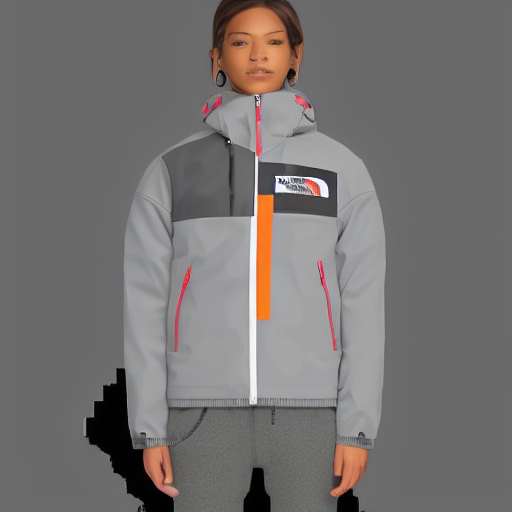

a pink plaid shirt on a beautiful beach


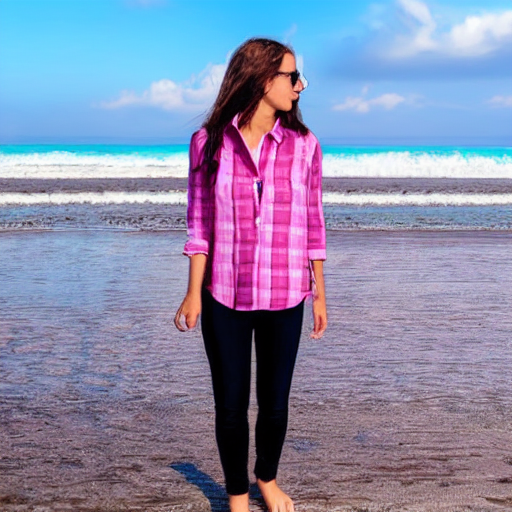

a deep orange sunset sky behind a pixel art character with a ufo-shaped head


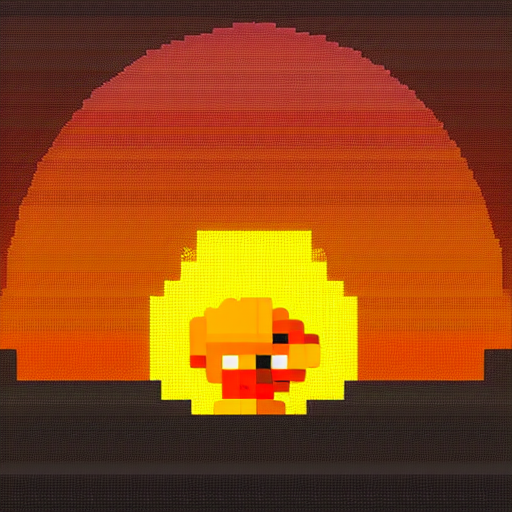

a mouse-shaped pixel character in front of a picturesque mountain filled with pine trees


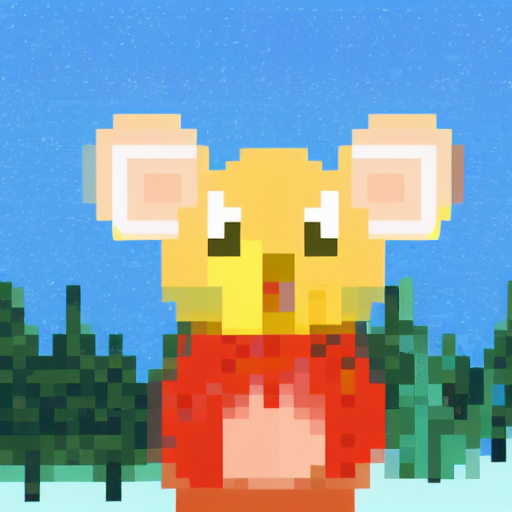

a white nike coat worn by a pixelated figure with an earth-shaped head


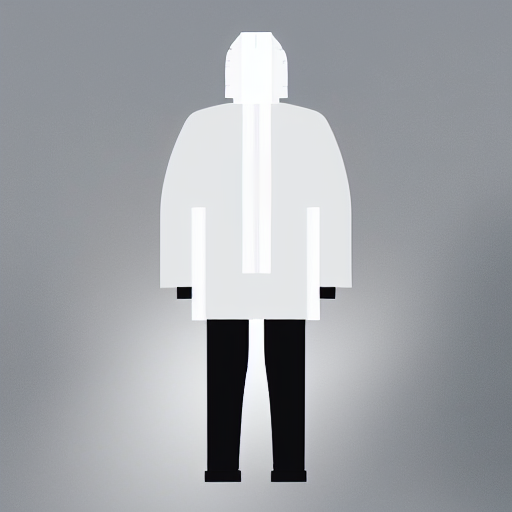

a pixelated character wearing a brown sweater under a stary midnight sky


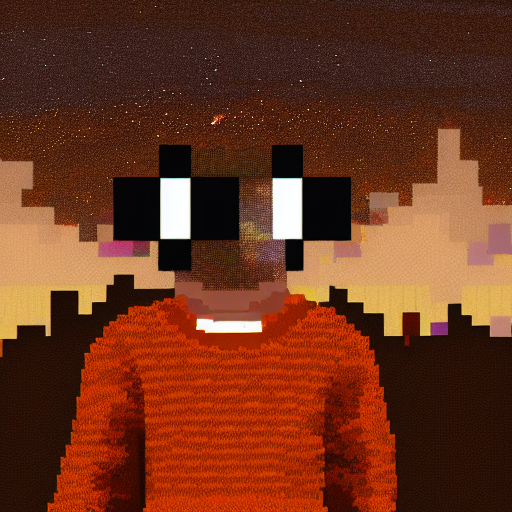

In [ ]:
from IPython.display import display # to display images
for image, prompt in zip(images, prompts):
    print(prompt)
    display(image)